## 코로나 공공데이터 불러오기

In [1]:
!pip install xmltodict

In [2]:
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
import urllib
import requests
import json
import pandas as pd
from datetime import datetime,timedelta
import xmltodict # 결과가 xml 형식으로 반환된다. 이것을 dict 로 바꿔주는 라이브러리다

start_date = '20200201'
end_date = datetime.today().strftime("%Y%m%d")

my_api_key = 'P6ELThVVcjDdxzKGrTQlvsBqBrVUl3jUo1p%2B6yaTuOdR4Mrw%2F7UNBRnkRKlR7vBmPWs4LksNPBKxvvD4ts8LgA%3D%3D'

# 서비스 url 주소
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'

# 서비스에 필요한 파라미터 모음
queryParams = '?' + \
'ServiceKey=' + '{}'.format(my_api_key) + \
'&pageNo='+ '1' + \
'&numOfRows='+ '999' + \
'&startCreateDt={}&endCreateDt={}'.format(start_date, end_date)

#서비스url에 필요한 파라미터들을 붙여서 응답결과를 얻음.
result = requests.get(url + queryParams)

# 응답결과 파싱하기. ( 사용자가 원하는 형태로 변경)
# 응답 key 값이 영문화 되어 식별이 어려워 openAPI 문서를 참고하여
# replace 를 통해 결과를 한글화 했다.

result = result.content 
jsonString = json.dumps(xmltodict.parse(result), indent = 4)
jsonString = jsonString.replace('resultCode', '결과코드').replace('resultMsg', '결과메세지').replace('numOfRows', '한 페이지 결과 수').replace('pageNo', '페이지 수').replace('totalCount', '전체 결과 수').replace('seq', '게시글번호(감염현황 고유값)').replace('stateDt', '기준일').replace('stateTime', '기준시간').replace('decideCnt', '확진자 수').replace('deathCnt', '사망자 수').replace('accExamCnt', '누적 검사 수').replace('accDefRate', '누적 환진률').replace('createDt', '등록일시분초').replace('updateDt', '수정일시분초')
js = json.loads(jsonString)

# 파싱한 전체 결과 보기.
js_check_count = js["response"]['body']['items']['item'][0]['확진자 수']
js = js["response"]['body']['items']['item']
corona_df = pd.DataFrame(js)
corona_df.head()

,누적 검사 수,등록일시분초,사망자 수,확진자 수,게시글번호(감염현황 고유값),기준일,기준시간,수정일시분초,누적 환진률
0,19040194,2021-12-26 07:59:54.187,5245,607463,739,20211226,00:00,null,NaN
1,18994820,2021-12-25 07:33:26.751,5176,602044,738,20211225,00:00,2021-12-26 08:01:29.666,NaN
2,18929158,2021-12-24 09:02:52.845,5071,596202,737,20211224,00:00,2021-12-26 08:01:21.022,NaN
3,18859285,2021-12-23 08:52:40.512,5015,589969,736,20211223,00:00,2021-12-26 08:01:12.336,NaN
4,18786344,2021-12-22 09:18:12.299,4906,583052,735,20211222,00:00,2021-12-26 08:01:03.41,NaN


In [3]:
corona_df.shape

(693, 9)

In [4]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   누적 검사 수          693 non-null    object
 1   등록일시분초           693 non-null    object
 2   사망자 수            693 non-null    object
 3   확진자 수            693 non-null    object
 4   게시글번호(감염현황 고유값)  693 non-null    object
 5   기준일              693 non-null    object
 6   기준시간             693 non-null    object
 7   수정일시분초           693 non-null    object
 8   누적 환진률           661 non-null    object
dtypes: object(9)
memory usage: 48.9+ KB


## 전처리

In [5]:
date = []
year = []
month = []
day = []

for data in corona_df['등록일시분초']:
    date.append(data.split()[0])
    year.append(data.split()[0].split('-')[0])
    month.append(data.split()[0].split('-')[1])
    day.append(data.split()[0].split('-')[2])

In [9]:
corona_df['등록일'] = date
corona_df['year'] = year
corona_df['month'] = month
corona_df['day'] = day

corona_df['year'] = corona_df['year'].astype('int64')
corona_df['month'] = corona_df['month'].astype('int64')
corona_df['day'] = corona_df['day'].astype('int64')
corona_df['사망자 수'] = corona_df['사망자 수'].astype('int64')
corona_df['확진자 수'] = corona_df['확진자 수'].astype('int64')
# corona_df['누적 환진률'] = corona_df['누적 환진률'].astype('int64')

In [10]:
corona_df['전날 확진자 수'] = corona_df['확진자 수'].shift(periods=-1, fill_value=0)
corona_df['전날 확진자 수'] = corona_df['전날 확진자 수'].astype('int64')

In [8]:
corona_df['당일 확진자 수'] = corona_df['확진자 수'] - corona_df['전날 확진자 수']
corona_df.head()

,누적 검사 수,등록일시분초,사망자 수,확진자 수,게시글번호(감염현황 고유값),기준일,기준시간,수정일시분초,누적 환진률,등록일,year,month,day,전날 확진자 수,당일 확진자 수
0,19040194,2021-12-26 07:59:54.187,5245,607463,739,20211226,00:00,null,NaN,2021-12-26,2021,12,26,602044,5419
1,18994820,2021-12-25 07:33:26.751,5176,602044,738,20211225,00:00,2021-12-26 08:01:29.666,NaN,2021-12-25,2021,12,25,596202,5842
2,18929158,2021-12-24 09:02:52.845,5071,596202,737,20211224,00:00,2021-12-26 08:01:21.022,NaN,2021-12-24,2021,12,24,589969,6233
3,18859285,2021-12-23 08:52:40.512,5015,589969,736,20211223,00:00,2021-12-26 08:01:12.336,NaN,2021-12-23,2021,12,23,583052,6917
4,18786344,2021-12-22 09:18:12.299,4906,583052,735,20211222,00:00,2021-12-26 08:01:03.41,NaN,2021-12-22,2021,12,22,575597,7455


## 월별 확진자 수

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
year_order = [2020, 2021]

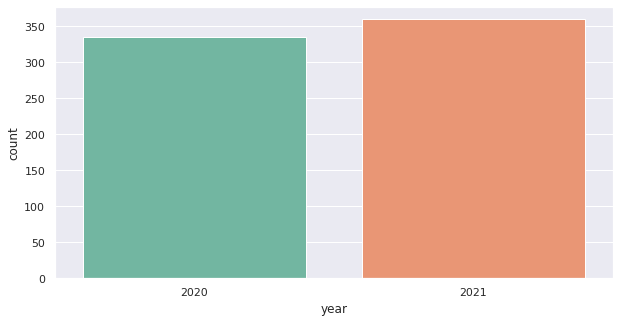

In [15]:
plt.figure(figsize=(10,5))

sns.set(style="darkgrid")
ax = sns.countplot(x="year", data=corona_df, palette="Set2", order = year_order)

In [ ]:
sns.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47197 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46321 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47197 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text

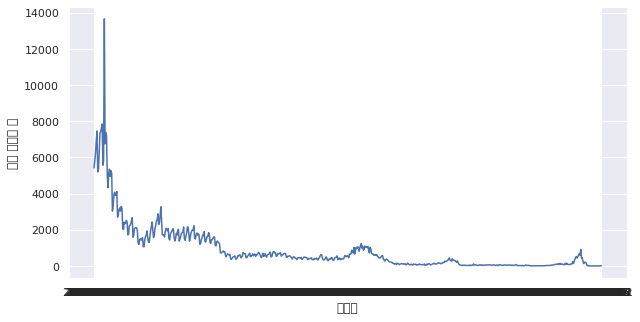

In [17]:
plt.figure(figsize=(10,5))

sns.set(style="darkgrid")
ax = sns.lineplot(x="year", y="당일 확진자 수", data=corona_df, palette="Set2")